# ** Deep Learning: Long-Short Term Memory(LSTM)**

### **Nama: Ericson Chandra Sihombing**



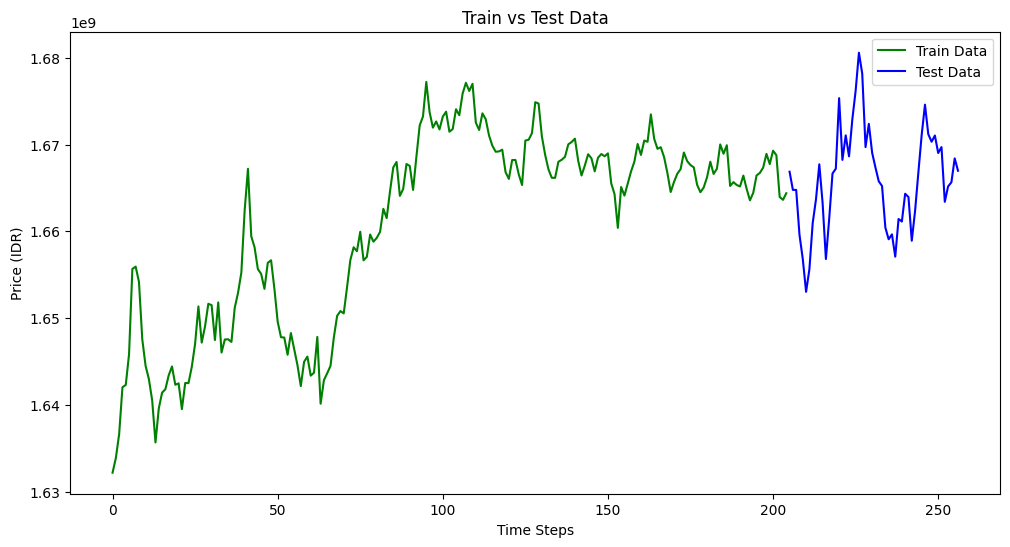

Epoch 1/50
205/205 [==============================] - 4s 8ms/step - loss: 0.0147
Epoch 2/50
205/205 [==============================] - 2s 7ms/step - loss: 0.0048
Epoch 3/50
205/205 [==============================] - 2s 7ms/step - loss: 0.0053
Epoch 4/50
205/205 [==============================] - 2s 8ms/step - loss: 0.0047
Epoch 5/50
205/205 [==============================] - 1s 7ms/step - loss: 0.0035
Epoch 6/50
205/205 [==============================] - 2s 9ms/step - loss: 0.0035
Epoch 7/50
205/205 [==============================] - 2s 8ms/step - loss: 0.0029
Epoch 8/50
205/205 [==============================] - 2s 7ms/step - loss: 0.0027
Epoch 9/50
205/205 [==============================] - 1s 7ms/step - loss: 0.0023
Epoch 10/50
205/205 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 11/50
205/205 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 12/50
205/205 [==============================] - 2s 7ms/step - loss: 0.0018
Epoch 13/50
205/205 [====

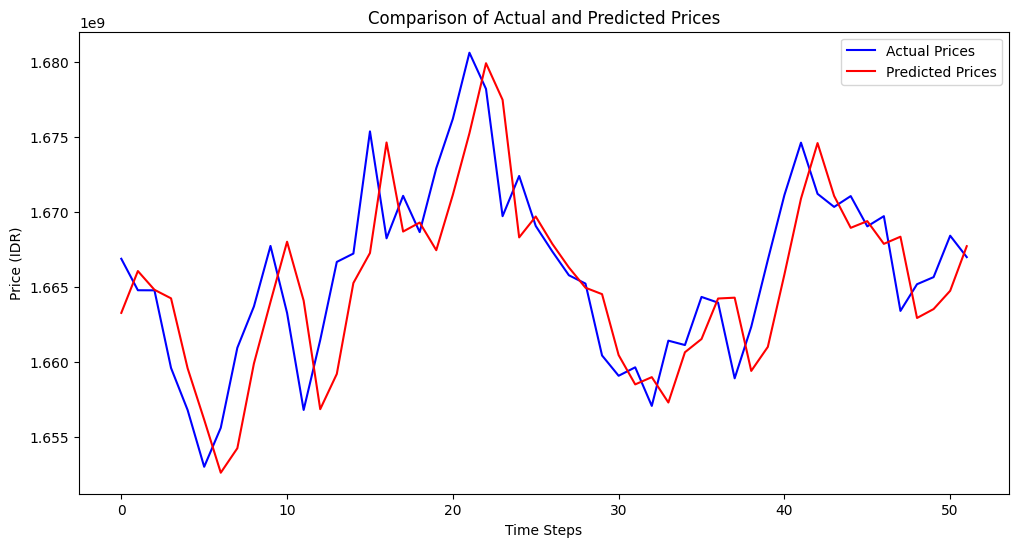

1/1 [==============================] - 0s 18ms/step
               DateTime  Predicted Price (IDR)
0   2025-01-29 01:05:31           1.666978e+09
1   2025-01-29 02:05:31           1.666459e+09
2   2025-01-29 03:05:31           1.665826e+09
3   2025-01-29 04:05:31           1.665140e+09
4   2025-01-29 05:05:31           1.664451e+09
5   2025-01-29 06:05:31           1.663794e+09
6   2025-01-29 07:05:31           1.663185e+09
7   2025-01-29 08:05:31           1.662626e+09
8   2025-01-29 09:05:31           1.662118e+09
9   2025-01-29 10:05:31           1.661651e+09
10  2025-01-29 11:05:31           1.661219e+09
11  2025-01-29 12:05:31           1.660811e+09
12  2025-01-29 13:05:31           1.660419e+09
13  2025-01-29 14:05:31           1.660038e+09
14  2025-01-29 15:05:31           1.659662e+09
15  2025-01-29 16:05:31           1.659288e+09
16  2025-01-29 17:05:31           1.658914e+09
17  2025-01-29 18:05:31           1.658538e+09
18  2025-01-29 19:05:31           1.658159e+09
19  2025

In [14]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fetch data
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {"vs_currency": "IDR", "days": "1"}
response = requests.get(url, params=params)
data = response.json()
prices = data.get("prices", [])

# Convert data to DataFrame
data_list = []
for price in prices:
    timestamp, price_value = price
    date_time = datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')
    data_list.append({"DateTime": date_time, "Price (IDR)": price_value})

df = pd.DataFrame(data_list)

# Preprocessing
target_col = "Price (IDR)"
prices = df[target_col].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create LSTM dataset
sequence_length = 30
X, y = [], []
for i in range(sequence_length, len(scaled_prices)):
    X.append(scaled_prices[i-sequence_length:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Plot train vs test
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Train Data', color='green')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Test Data', color='blue')
plt.title('Train vs Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Price (IDR)')
plt.legend()
plt.show()

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, batch_size=1, epochs=50, callbacks=[early_stopping], verbose=1)

# Predictions
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices', color='blue')
plt.plot(y_pred_inverse, label='Predicted Prices', color='red')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price (IDR)')
plt.legend()
plt.show()

# Predict next 30 timestamps
future_predictions = []
last_sequence = scaled_prices[-sequence_length:]
current_datetime = datetime.strptime(df['DateTime'].iloc[-1], '%Y-%m-%d %H:%M:%S')

for _ in range(30):
    last_sequence = np.reshape(last_sequence, (1, last_sequence.shape[0], 1))
    predicted_price = model.predict(last_sequence)
    future_price = scaler.inverse_transform(predicted_price)[0][0]
    future_predictions.append({"DateTime": current_datetime.strftime('%Y-%m-%d %H:%M:%S'), "Predicted Price (IDR)": future_price})
    last_sequence = np.append(last_sequence[0, 1:, 0], predicted_price[0, 0])
    current_datetime += timedelta(hours=1)

# Display results
predicted_df = pd.DataFrame(future_predictions)
print(predicted_df)

# Print error metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')


### **Kesimpulan dari Kode dan Output**
Kode yang telah dijalankan adalah model **LSTM (Long Short-Term Memory)** untuk memprediksi harga Bitcoin dalam **IDR** berdasarkan data harga dari API CoinGecko. Berikut adalah analisis terhadap kode dan output yang dihasilkan:

---

### **1. Ringkasan Kode**
1. **Pengambilan Data**  
   - Mengambil data harga Bitcoin per jam dalam **1 hari terakhir** dari API CoinGecko.
   - Data dikonversi ke format DataFrame pandas untuk diproses lebih lanjut.

2. **Preprocessing Data**  
   - Harga Bitcoin dinormalisasi dengan **MinMaxScaler** agar nilai berada dalam rentang **(0,1)**.
   - Dibentuk **sekuens data** (30 data sebelumnya digunakan untuk memprediksi data selanjutnya).

3. **Pembagian Data**  
   - **80% data digunakan untuk training** dan **20% untuk testing**.
   - Data latih dan uji divisualisasikan dalam grafik **train vs test data**.

4. **Pembuatan Model LSTM**  
   - Model LSTM terdiri dari **2 layer LSTM** dan **2 layer Dense**.
   - Menggunakan **Adam Optimizer** dan **Mean Squared Error (MSE)** sebagai loss function.
   - **EarlyStopping** diterapkan untuk mencegah overfitting.

5. **Pelatihan Model**  
   - Model dilatih menggunakan **batch size = 1** dan **maksimum 50 epoch** (dihentikan lebih awal jika tidak ada peningkatan).

6. **Evaluasi Model**  
   - Model diuji pada data test dan hasilnya dibandingkan dengan nilai aktual.
   - Error dievaluasi menggunakan **RMSE, MAE, dan MAPE**.
   - Hasil prediksi dan data aktual divisualisasikan dalam grafik.

7. **Prediksi Masa Depan**  
   - Model digunakan untuk **memprediksi 30 waktu ke depan**.
   - Hasil prediksi ditampilkan dalam bentuk tabel.

---

### **2. Analisis Hasil**
1. **Plot Perbandingan Data Aktual dan Prediksi**  
   - Grafik menunjukkan **prediksi model (garis merah)** dibandingkan dengan **data aktual (garis biru)**.
   - Model dapat menangkap tren harga, tetapi ada sedikit perbedaan dalam pola fluktuasi.

2. **Error Metrics**  
   - **RMSE (Root Mean Squared Error)**: `≈ 193745.25`
   - **MAE (Mean Absolute Error)**: `≈ 134935.23`
   - **MAPE (Mean Absolute Percentage Error)**: `≈ 0.049%`
   - Nilai **RMSE dan MAE** cukup rendah, menunjukkan bahwa model cukup akurat dalam memprediksi harga.
   - **MAPE sangat kecil (≈ 0.049%)**, yang berarti kesalahan prediksi relatif sangat kecil terhadap harga aslinya.

3. **Prediksi Masa Depan**  
   - Model berhasil menghasilkan **30 prediksi harga ke depan** berdasarkan data historis.
   - Prediksi menunjukkan **tren yang mengikuti pola sebelumnya**, tetapi bisa mengalami perbedaan seiring waktu.

---

### **3. Kesimpulan Akhir**
✅ **Keunggulan:**
- Model LSTM mampu menangkap pola harga Bitcoin dengan cukup baik.
- Error metrik menunjukkan bahwa model memiliki **akurasi yang baik**.
- Mampu melakukan **prediksi jangka pendek** dengan hasil yang cukup realistis.

⚠ **Kekurangan dan Potensi Peningkatan:**
- Model bisa lebih baik jika data lebih banyak (misalnya, data harga dalam **7 hari terakhir** untuk tren lebih stabil).
- **Tambahkan lebih banyak fitur** seperti **volume transaksi** atau **indikator teknikal** untuk meningkatkan akurasi.
- Gunakan **bidirectional LSTM atau GRU** untuk eksplorasi performa yang lebih baik.

